In [1]:
import os
import pydicom
import numpy as np
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_modality_lut

def load_dicom_image_with_lut(dicom_path):
    try:
        # Read the DICOM file
        ds = pydicom.dcmread(dicom_path)
        
        # Extract the pixel data
        arr = ds.pixel_array
        
        # Apply the Modality LUT transformation
        hu = apply_modality_lut(arr, ds)
        
        return hu
    except Exception as e:
        # Handle any exceptions that may occur while processing the DICOM file
        print(f"Error loading DICOM image: {str(e)}")
        return None
# Define the root directory where your data is stored
data_root = "../FProject/Data/Train_Sets/CT"

# Iterate through patient folders
patient_data = {}  # Dictionary to store (patient_folder, image, mask) pairs

for patient_folder in os.listdir(data_root):
    if os.path.isdir(os.path.join(data_root, patient_folder)):
        dicom_folder = os.path.join(data_root, patient_folder, "DICOM_anon")
        ground_folder = os.path.join(data_root, patient_folder, "Ground")

        # Check if DICOM and Ground folders exist for the patient
        if os.path.exists(dicom_folder) and os.path.exists(ground_folder):
            dicom_files = os.listdir(dicom_folder)
            ground_files = os.listdir(ground_folder)

            # Ensure both folders have the same number of files
            if len(dicom_files) == len(ground_files):
                patient_image_mask_pairs = []  # List to store (image, mask) pairs for this patient

                for dicom_file, ground_file in zip(dicom_files, ground_files):
                    dicom_path = os.path.join(dicom_folder, dicom_file)
                    ground_path = os.path.join(ground_folder, ground_file)

                    # Load DICOM files using pydicom and apply Modality LUT
                    dicom_array = load_dicom_image_with_lut(dicom_path)

                    # Load Ground images using PIL (or any other suitable library) and convert to NumPy array
                    ground = Image.open(ground_path)
                    ground_array = np.array(ground)

                    # Append the (image, mask) pair to the patient's list
                    patient_image_mask_pairs.append((dicom_array, ground_array))

                # Store the (image, mask) pairs for this patient in the dictionary
                patient_data[patient_folder] = patient_image_mask_pairs

# Now, patient_data is a dictionary where keys are patient identifiers, and values are lists of (DICOM, mask) pairs as NumPy arrays for each patient


In [4]:
import random

# Get a list of all patient identifiers
patient_ids = list(patient_data.keys())

# Define the number of patients for each split
num_train_patients = 15
num_val_patients = 4
num_test_patients = 1

# Shuffle the list of patient identifiers
random.shuffle(patient_ids)

# Split the patients into training, validation, and testing sets
train_patients = patient_ids[:num_train_patients]
val_patients = patient_ids[num_train_patients:num_train_patients + num_val_patients]
test_patients = patient_ids[-num_test_patients:]

# Create dictionaries for each split
train_data = {patient: patient_data[patient] for patient in train_patients}
val_data = {patient: patient_data[patient] for patient in val_patients}
test_data = {patient: patient_data[patient] for patient in test_patients}

# Now you have train_data, val_data, and test_data dictionaries with the selected patients and their (DICOM, mask) pairs.

# For train_data
train_pairs = [(image, mask) for patient_data in train_data.values() for (image, mask) in patient_data]

# For val_data
val_pairs = [(image, mask) for patient_data in val_data.values() for (image, mask) in patient_data]

# For test_data
test_pairs = [(image, mask) for patient_data in test_data.values() for (image, mask) in patient_data]


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 512, 512, 16  64         ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

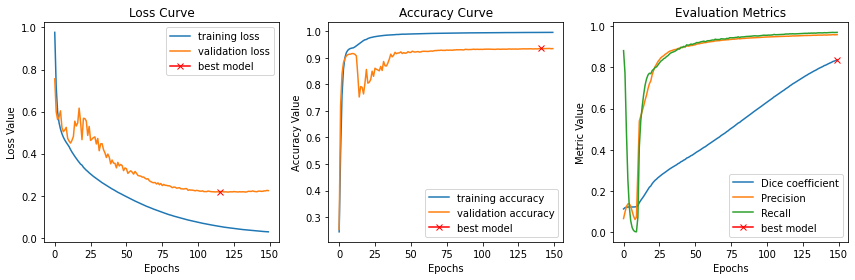

In [6]:
import numpy as np
import pydicom
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, MaxPooling2D,
    concatenate, Dropout, ReLU, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from Unet import conv_block, get_unet
from Functions import plotcurve, dice_coefficient, recall, precision, dice_loss


# Define your parameters
base = 16
img_h = 512
img_w = 512
img_ch = 1
batch_size = 8
learning_rate = 1e-5
dropout = True
dr = 0.2
batch_norm = True
num_epochs = 150
img_size= 512



# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=5,
    fill_mode='nearest')


def data_generator(data, batch_size):
    while True:
        batch_indices = np.random.choice(len(data), batch_size)
        batch_images = []
        batch_masks = []


        for idx in batch_indices:
            image, mask = data[idx]  # Assuming data is a list of tuples with pre-loaded images and masks as numpy arrays

            # Ensure image and mask are numpy arrays
            image = np.array(image, dtype=np.float32)
            mask = np.array(mask, dtype=np.float32)

            # Normalize image and mask
            image = normalize_image(image)
            mask = normalize_mask(mask)

            # Expand dimensions to make them multi-channel
            image = np.expand_dims(image, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            # Apply data augmentation to image and mask
            seed = np.random.randint(0, 1000)
            augmented_image = datagen.random_transform(image, seed=seed)
            augmented_mask = datagen.random_transform(mask, seed=seed)

            batch_images.append(augmented_image)
            batch_masks.append(augmented_mask)

        yield np.array(batch_images), np.array(batch_masks)


# Define the normalize_image and normalize_mask functions here
def normalize_image(image):
    # Implement your normalization logic here, scaling to [0, 1] based on the provided max_value
    return image / 1400

def normalize_mask(mask):
    # Ensure mask values are boolean (True/False)
    return mask.astype(bool)

# Create the U-Net model
modela = get_unet(img_h, img_w, img_ch, base, batch_norm, dropout, dr)

def dice_coefficient(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure y_true has the same data type as y_pred
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.0 * intersection + 1e-5) / (union + 1e-5)

# Define precision metric
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

# Define recall metric
def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    actual_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())
    return recall

# Compile the model
modela.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['binary_accuracy',precision, recall,dice_coefficient])

# Train the model
train_generator = data_generator(train_pairs, batch_size)
val_generator = data_generator(val_pairs, batch_size)

historya = modela.fit(
    train_generator,
    validation_data=val_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_pairs) // batch_size,
    validation_steps=len(val_pairs) // batch_size)

plotcurve(historya,'binary')

In [7]:
modela.save("unet_model.h5")

from tensorflow import keras

model = keras.models.load_model("unet_model.h5",custom_objects={'precision':precision,'recall':recall,'dice_coefficient':dice_coefficient})


In [76]:
import cv2 

# Initialize lists for images and masks
test_images = []
test_masks = []

# Iterate through the test_data list
for image, mask in test_pairs: 
    test_images.append(image)
    test_masks.append(mask)

# Now, test_images contains only the images, and test_masks contains the corresponding masks

import os

predicted_masks = []  # To store the predicted masks

    
output_dir = "../FProject/Data/Predicted_masks"  # Directory to save the predicted masks
os.makedirs(output_dir, exist_ok=True)

for i, image in enumerate(test_images):
    # Preprocess the image
    image = normalize_image(image)  # Make sure this function returns a NumPy array

    # Predict the mask
    predicted_mask = model.predict(np.expand_dims(image, axis=0))

    # Ensure predicted_mask is a 2D array
    predicted_mask = predicted_mask[0, :, :, 0]  # Extract the first (and only) channel
    
    # Scale the predicted mask to the range [0, 255]
    predicted_mask = (predicted_mask * 255).astype(np.uint8)
    
    # Apply a threshold to make the mask binary
    threshold = 128 # Adjust this threshold as needed
    predicted_mask_binary = np.where(predicted_mask > threshold, 255, 0).astype(np.uint8)
    
    # Convert to PIL Image
    predicted_mask_image = Image.fromarray(predicted_mask_binary.astype(np.uint8), mode="L")

    # Save the predicted mask
    predicted_mask_path = os.path.join(output_dir, f"predicted_mask_{i}.png")
    predicted_mask_image.save(predicted_mask_path)

    # Convert the true mask to a NumPy array and extract the first channel
    true_mask = img_to_array(test_masks[i])[:, :, 0]

    # Save the corresponding true mask
    true_mask_path = os.path.join(output_dir, f"true_mask_{i}.png")
    true_mask = (true_mask * 255).astype(np.uint8)
    true_mask_image = Image.fromarray(true_mask, mode="L")
    true_mask_image.save(true_mask_path)


1/1 [==============================] - 0s 19ms/step


In [73]:
import os
from PIL import Image
import numpy as np

def calculate_dice_coefficient(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    dice_coefficient = (2.0 * intersection.sum()) / (mask1.sum() + mask2.sum())
    # Check if the denominator is zero and handle it
    if (mask1.sum() + mask2.sum()) == 0:
        return 1.0  # If the denominator is zero, set the Dice score to 1.0
    else:
        return dice_coefficient

# Assuming you have your patient data as a dictionary (patient_data), which contains (DICOM, mask) pairs for each patient
patient_dice_scores = {}

for patient_id, patient_info in patient_data.items():
    patient_dice_scores[patient_id] = []  # Initialize a list for Dice scores for this patient
    for (image, true_mask) in patient_info:
    # Preprocess the image
        image = normalize_image(image)  # Make sure this function returns a NumPy array

        # Predict the mask (Assuming you have a trained segmentation model)
        predicted_mask = model.predict(np.expand_dims(image, axis=0))

        # Ensure predicted_mask is a 2D array
        predicted_mask = predicted_mask[0, :, :, 0]  # Extract the first (and only) channel

        # Apply a threshold to make the mask binary
        threshold = 0.1  # Adjust this threshold as needed
        predicted_mask_binary = (predicted_mask > threshold).astype(bool)

        # Calculate the Dice score for this slice
        dice_score = calculate_dice_coefficient(true_mask, predicted_mask_binary)

        # Append the Dice score to the patient's list
        patient_dice_scores[patient_id].append(dice_score)


# Calculate the average Dice score for each patient
average_patient_dice_scores = {}
for patient_id, dice_scores in patient_dice_scores.items():
    if dice_scores:  # Check if there are any dice scores for the patient
        average_score = sum(dice_scores) / len(dice_scores)
        average_patient_dice_scores[patient_id] = average_score
    else:
        average_patient_dice_scores[patient_id] = 0.0  # Handle the case of no dice scores

# Now, average_patient_dice_scores contains the average Dice score for each patient.



1/1 [==============================] - 0s 19ms/step


<ipython-input-73-29eb941b8ee1>:7: RuntimeWarning: invalid value encountered in double_scalars
  dice_coefficient = (2.0 * intersection.sum()) / (mask1.sum() + mask2.sum())


1/1 [==============================] - 0s 20ms/step


In [74]:
average_patient_dice_scores

{'30': 0.2851130293593005,
 '28': 0.5881289051179398,
 '24': 0.3510076491278431,
 '27': 0.35528857410064874,
 '8': 0.32296076062705315,
 '22': 0.5763053706255673,
 '23': 0.33905368784240153,
 '21': 0.23862757348187938,
 '10': 0.49622932330681524,
 '6': 0.5116853433807257,
 '2': 0.4854144140325107,
 '14': 0.41963499235525903,
 '19': 0.5489733333048784,
 '18': 0.5951616537114469,
 '1': 0.46843638545800587,
 '16': 0.5602585807809353,
 '25': 0.1801269071081871,
 '5': 0.5518588066429664,
 '26': 0.41806932110870393,
 '29': 0.32617263697400023}